In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from enum import Enum
import dynamicDIA as dDIA

plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams.update({'font.size': 22})

### Read chromatogram library data

In [2]:
psms = pd.read_csv('..\\data\\RT_DIA_Scheduling.csv')

### Reformat and plot features

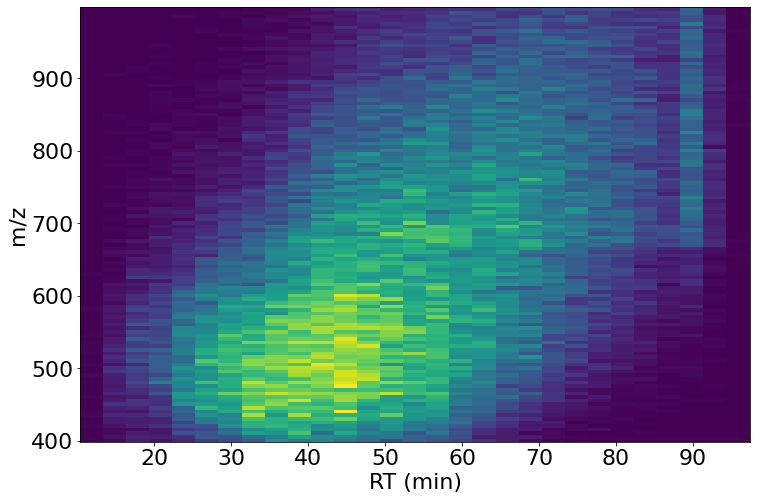

In [3]:

mz, rt = [],[]

mz = psms.loc[:,'Precursor Mz']
mz = mz.values

rt = psms.loc[:,'Average Measured Retention Time']
rt = rt.values
df = pd.DataFrame(data={'mz': mz, 'rt':rt})

fig,ax = plt.subplots()
rt_bin_size_min = 3
mz_bins_size = 5
ax.set_xlabel('RT (min)')
ax.set_ylabel('m/z')
rt_edges = np.arange(np.min(rt), np.max(rt), rt_bin_size_min)
mz_edges = np.arange(np.min(mz), np.max(mz), mz_bins_size)
hist = ax.hist2d(rt, mz, bins=[rt_edges, mz_edges])[0];

### Normalize and plot normalized features

Text(0.5, 1.0, 'Histogram of Identified Peptides (Normalized for each RT)')

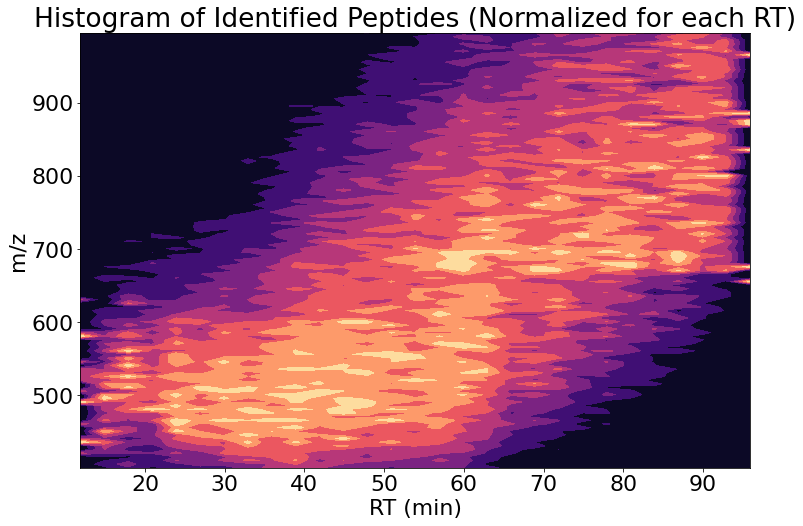

In [4]:
normalized_hist = np.zeros_like(hist)
for ridx,row in enumerate(hist):
    norm_row = np.max(row)
    if norm_row > 0.0:
        normalized_hist[ridx, :] = [x/norm_row for x in row]
        
fig,ax = plt.subplots()
rt_axis = [0.5*(x+y) for x,y in zip(rt_edges[1:], rt_edges[:-1])]
mz_axis = [0.5*(x+y) for x,y in zip(mz_edges[1:], mz_edges[:-1])]
CS = ax.contourf(rt_axis, mz_axis, np.transpose(normalized_hist), cmap='magma')
ax.set_xlabel('RT (min)')
ax.set_ylabel('m/z')
ax.set_title('Histogram of Identified Peptides (Normalized for each RT)')

### Specify instrument parameters

In [5]:
isolation_width_th = 8
instrument_speed_hz = 14.6
cycle_time_sec = 2.5

### Perform window selection

In [6]:
low_mz_values, high_mz_values, total_num_peptides = dDIA.compute_precursor_locations(isolation_width_th, instrument_speed_hz, cycle_time_sec, hist, mz_axis)
scheduled_dia = dDIA.create_scheduled_dia_scans(rt_axis, low_mz_values, high_mz_values, isolation_width_th, 1.00045475,  0.25)

### Plot resulting method

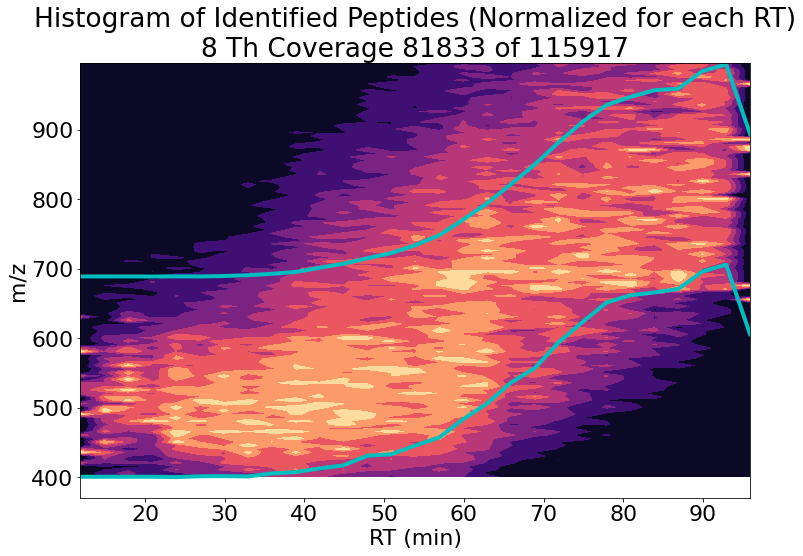

In [7]:
fig,ax = plt.subplots(figsize=(12,8))
CS = ax.contourf(rt_axis, mz_axis, np.transpose(normalized_hist), cmap='magma')
ax.set_xlabel('RT (min)')
ax.set_ylabel('m/z')
ax.set_title('Histogram of Identified Peptides (Normalized for each RT)\n{0} Th Coverage {1:.0f} of {2}'.format(isolation_width_th, total_num_peptides, len(mz)))
ax.plot(rt_axis, low_mz_values, color='c', linewidth=4)
ax.plot(rt_axis, high_mz_values, color='c', linewidth=4)

### Save method

In [12]:
dDIA.save_scheduled_dia_scans(
     f'scheduled_dia_{isolation_width_th:.0f}Th_{instrument_speed_hz:.1f}Hz_{cycle_time_sec:.2f}sec.csv',
    scheduled_dia
)